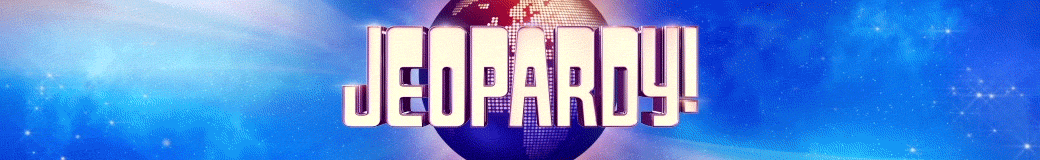

## Project: Winning Jeopardy:

#### Introduction: 

Jeopardy is a game show in the US where participants answer questions to win money. 

Imagine that you want to compete on Jeopardy, and you're looking for any way to win. In this project, I'll work with a dataset of Jeopardy questions to figure out some patterns in the questions that could help you win.

The dataset being used can be found here on [Reddit.](https://www.reddit.com/r/datasets/comments/1uyd0t/200000_jeopardy_questions_in_a_json_file/)

#### Exploring and cleaning dataset: 

In [222]:
import pandas as pd 
import numpy as np
import re 
from scipy.stats import chisquare
import random 
from random import choice

jeopardy = pd.read_csv('jeopardy.csv')

In [223]:
jeopardy.head()

,Show Number,Air Date,Round,Category,Value,Question,Answer
0,4680,2004-12-31,Jeopardy!,HISTORY,$200,"For the last 8 years of his life, Galileo was ...",Copernicus
1,4680,2004-12-31,Jeopardy!,ESPN's TOP 10 ALL-TIME ATHLETES,$200,No. 2: 1912 Olympian; football star at Carlisl...,Jim Thorpe
2,4680,2004-12-31,Jeopardy!,EVERYBODY TALKS ABOUT IT...,$200,The city of Yuma in this state has a record av...,Arizona
3,4680,2004-12-31,Jeopardy!,THE COMPANY LINE,$200,"In 1963, live on ""The Art Linkletter Show"", th...",McDonald's
4,4680,2004-12-31,Jeopardy!,EPITAPHS & TRIBUTES,$200,"Signer of the Dec. of Indep., framer of the Co...",John Adams


In [224]:
jeopardy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19999 entries, 0 to 19998
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Show Number  19999 non-null  int64 
 1    Air Date    19999 non-null  object
 2    Round       19999 non-null  object
 3    Category    19999 non-null  object
 4    Value       19999 non-null  object
 5    Question    19999 non-null  object
 6    Answer      19999 non-null  object
dtypes: int64(1), object(6)
memory usage: 1.1+ MB


In [225]:
jeopardy.columns

Index(['Show Number', ' Air Date', ' Round', ' Category', ' Value',
       ' Question', ' Answer'],
      dtype='object')

In [226]:
#cleaning column names quickly
jeopardy.columns = jeopardy.columns.str.strip()

jeopardy.columns

Index(['Show Number', 'Air Date', 'Round', 'Category', 'Value', 'Question',
       'Answer'],
      dtype='object')

In [227]:
#function to clean the question and answer column

def text_clean(text):
    text = re.sub('\W', ' ', text) 
    text = text.lower()
    return text 

In [228]:
#applying function and creating new columns

jeopardy['clean_question'] = jeopardy['Question'].apply(text_clean)
jeopardy['clean_answer'] = jeopardy['Answer'].apply(text_clean)

jeopardy['clean_question']

0        for the last 8 years of his life  galileo was ...
1        no  2  1912 olympian  football star at carlisl...
2        the city of yuma in this state has a record av...
3        in 1963  live on  the art linkletter show   th...
4        signer of the dec  of indep   framer of the co...
                               ...                        
19994    of 8  12 or 18  the number of u s  states that...
19995                             the new power generation
19996    in 1589 he was appointed professor of mathemat...
19997    before the grand jury she said   i m really so...
19998    llamas are the heftiest south american members...
Name: clean_question, Length: 19999, dtype: object

In [229]:
jeopardy['Value'].unique()

array(['$200', '$400', '$600', '$800', '$2,000', '$1000', '$1200',
       '$1600', '$2000', '$3,200', 'None', '$5,000', '$100', '$300',
       '$500', '$1,000', '$1,500', '$1,200', '$4,800', '$1,800', '$1,100',
       '$2,200', '$3,400', '$3,000', '$4,000', '$1,600', '$6,800',
       '$1,900', '$3,100', '$700', '$1,400', '$2,800', '$8,000', '$6,000',
       '$2,400', '$12,000', '$3,800', '$2,500', '$6,200', '$10,000',
       '$7,000', '$1,492', '$7,400', '$1,300', '$7,200', '$2,600',
       '$3,300', '$5,400', '$4,500', '$2,100', '$900', '$3,600', '$2,127',
       '$367', '$4,400', '$3,500', '$2,900', '$3,900', '$4,100', '$4,600',
       '$10,800', '$2,300', '$5,600', '$1,111', '$8,200', '$5,800',
       '$750', '$7,500', '$1,700', '$9,000', '$6,100', '$1,020', '$4,700',
       '$2,021', '$5,200', '$3,389'], dtype=object)

In [230]:
#cleaning the value column and converting to integer
jeopardy['Value'] = jeopardy['Value'].str.replace('$','', regex=True)
jeopardy['Value'] = jeopardy['Value'].str.replace(',','', regex=True)
jeopardy['Value'] = jeopardy['Value'].str.replace('None','0', regex=True)

jeopardy['Value'] = jeopardy['Value'].astype('int64')

#changing airdate column to datetime

jeopardy['Air Date'] = pd.to_datetime(jeopardy['Air Date'])

In [231]:
jeopardy.dtypes

Show Number                int64
Air Date          datetime64[ns]
Round                     object
Category                  object
Value                      int64
Question                  object
Answer                    object
clean_question            object
clean_answer              object
dtype: object

### Answers in Questions: 

Now in order to determine if studying past questions will be useful we will need to see 

1) how often an answer can be used for a question?
2) how often do questions repeat?

I'll start with the first question. Lets start by creating a function to count how many times a word occurs in clean answer and clean question columns. 

In [232]:
def mr_clean(row):
    split_answer = row['clean_answer'].split()
    split_question = row['clean_question'].split()
    match_count = 0
    
    #removing the word the since it is meaningless for our purpose
    if 'the' in split_answer: 
        split_answer.remove('the')
    
    #to avoid error dividing by 0     
    if len(split_answer) == 0:
        return 0
    
    for word in split_answer:
        if word in split_question: 
            match_count += 1 
        return match_count / len(split_answer)
        

In [233]:
#applying function to the dataframe and making new column 

jeopardy['answer_in_question'] = jeopardy.apply(mr_clean, axis=1)

jeopardy['answer_in_question'].unique()

array([0.        , 0.5       , 0.33333333, 0.25      , 1.        ,
       0.16666667, 0.14285714, 0.2       , 0.08333333, 0.125     ,
       0.1       , 0.11111111, 0.05      ])

In [234]:
jeopardy['answer_in_question'].mean()

0.030083210509731836

Looking at the mean and unique values I can determine that using an answer for a question in Jeopardy would not be beneficial. It occurs only 3% of the time according to the function I created. 

Lets see how often questions repeat themselves. 

### Recycled Questions:

Now the dataset I am using is only about 10% of questions Jeopardy has used. Looking at this sample of questions will only give me an idea if its worth further exploring or not. 

In [235]:
question_overlap = []
terms_used = set()

jeopardy = jeopardy.sort_values('Air Date')

for row in jeopardy.iterrows():
    row = row[1]
    split_question = row['clean_question'].split(' ')
    split_question = [word for word in split_question if len(word) > 5]
    match_count = 0
        
    for word in split_question:
        if word in terms_used: 
            match_count += 1 
    
    for word in split_question: 
        terms_used.add(word)
    if len(split_question) > 0: 
        match_count /= len(split_question)
    question_overlap.append(match_count)
            
jeopardy['question_overlap'] = question_overlap

In [236]:
jeopardy['question_overlap'].mean()

0.7197989717809739

In [237]:
jeopardy['question_overlap'].value_counts()

1.000000    7110
0.500000    1916
0.666667    1795
0.000000    1542
0.750000    1524
            ... 
0.562500       1
0.545455       1
0.125000       1
0.521739       1
0.947368       1
Name: question_overlap, Length: 83, dtype: int64

The mean of repeated questions is about 72%. This is really high and would indicate we might have alot of repeated questions.  The method used is a bit misleading since we are looking at words matching and not exact answers given. Also we have to take into account that this is only 10% of all questions. I personally would not discount using the questions as a study guide but I would also explore other sources as well. 

### Low Value vs High Value Questions: 

In this part I will sample a list of words and see how the word usage compares tolow and high value questions.


In [238]:
# function to mark high value, values and low values. 

def mr_value(row):
    if row ['Value'] > 800: 
        value = 1 
    else: 
        value = 0
    return value     
    
    
jeopardy['high_value'] = jeopardy.apply(mr_value, axis=1)    

jeopardy[['Value', 'high_value']].head(20)

,Value,high_value
19325,0,0
19301,200,0
19302,200,0
19303,200,0
19304,200,0
19305,200,0
19306,200,0
19307,400,0
19308,400,0
19309,400,0


In [239]:
#function to match words with low or high values

def mr_count(word):
    low_count = 0
    high_count = 0
    for i, row in jeopardy.iterrows():
        if word in row['clean_question'].split(" "):
            if row['high_value']==1:
                high_count += 1
            else:
                low_count += 1
    return high_count, low_count

terms_used_list = list(terms_used)
comparison_terms = [choice(terms_used_list) for _ in range(10)]

observed_expected = []
for w in comparison_terms:
    observed_expected.append(mr_count(w))
    
observed_expected
        

[(0, 2),
 (46, 147),
 (1, 3),
 (2, 7),
 (0, 1),
 (9, 29),
 (0, 2),
 (0, 1),
 (0, 2),
 (2, 6)]

In [241]:
high_value_count = jeopardy[jeopardy['high_value'] == 1].shape[0]
low_value_count = jeopardy[jeopardy['high_value'] == 0].shape[0]

chi_squared = []
for value in observed_expected:
    total = sum(value)
    total_prop = total / jeopardy.shape[0]
    exp_high = high_value_count * total_prop
    exp_low = low_value_count * total_prop
    
    observed = np.array([value[0], value[1]])
    expected = np.array([exp_low, exp_high])
    chi_squared.append(chisquare(observed, expected))
    
chi_squared

[Power_divergenceResult(statistic=4.97558423439135, pvalue=0.025707519787911092),
 Power_divergenceResult(statistic=212.8769598076985, pvalue=3.237535575266361e-48),
 Power_divergenceResult(statistic=4.198022975221989, pvalue=0.0404711362009595),
 Power_divergenceResult(statistic=10.612185014121733, pvalue=0.0011234485390693592),
 Power_divergenceResult(statistic=2.487792117195675, pvalue=0.11473257634454047),
 Power_divergenceResult(statistic=42.178741081522105, pvalue=8.33006490352555e-11),
 Power_divergenceResult(statistic=4.97558423439135, pvalue=0.025707519787911092),
 Power_divergenceResult(statistic=2.487792117195675, pvalue=0.11473257634454047),
 Power_divergenceResult(statistic=4.97558423439135, pvalue=0.025707519787911092),
 Power_divergenceResult(statistic=8.396045950443979, pvalue=0.0037603807435239184)]

There does not appear to be a strong correlation between words and values. We have a mixed group of results.

### Conclusion: 

I can determine based on the dataset used that there is not an exact method to study for Jeopardy. 
Using the old questions will still be a good idea to get a feel of how broad the question and topics are. 
The best way to prepare is to just learn about all different subjects and categories. 
